In [1]:
import numpy as np
import pandas as pd
import json
from IPython.display import Image
import os
import shutil
import cv2
from matplotlib import pyplot as plt
from keras import backend as K
import tensorflow as tf
import sys
from tensorflow.keras import layers
from tensorflow import keras
from keras import models

Using TensorFlow backend.


In [2]:
tf.__version__

'2.3.0'

In [4]:
model = tf.keras.models.load_model("model250_s", compile=False)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 205, 205, 64)      9472      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 205, 205, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 102, 102, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 192)       602304    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 192)      

In [5]:
# 000000009993, 000000000194

img_path = f'two_objects/000000052179.jpg'
img = cv2.imread(img_path)
img = np.expand_dims(img, axis=0)
output = model.predict(img)
print(output.shape)

(1, 169, 7)


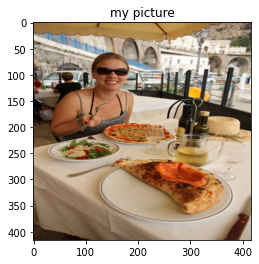

In [6]:
# img = cv2.imread('two_objects/000000000321.jpg') 
plt.imshow(img[0,:,:,::-1])
plt.title('my picture')
plt.show()

(1, 416, 416, 3)
(1, 96, 96, 192)


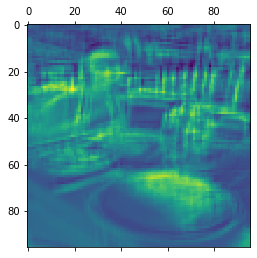

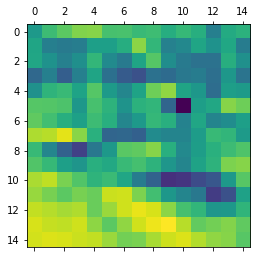

In [7]:
layer_outputs = [layer.output for layer in model.layers[:9]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(img.shape)
activations = activation_model.predict(img)

print(activations[5].shape)
plt.matshow(activations[5][0, :, : , 4], cmap='viridis')
plt.matshow(activations[8][0, :, : , 12], cmap='viridis')

[16, 16]
ground truth i 113
[0.4388962  0.6282526  0.36257273 0.50166553 0.2054686 ]
ground truth i 126
[0.05486584 0.72456515 0.85138875 0.42242214 0.16446507]
**************************************************
(13, 13, 7)
ground truth i 84
[1.         0.48197115 0.51081731 0.32451923 0.09855769]
ground truth i 113
[1.         0.62019231 0.75721154 0.50961538 0.25961538]


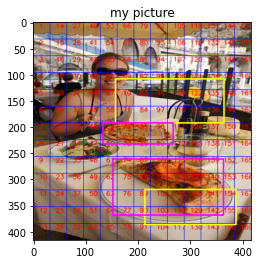

In [8]:
# for 2D
#000000000194
f = open('center.json')
dic = json.load(f)
print(dic['1'])

kimg = cv2.imread(img_path)

GRID_SIZE = 32

height, width, channels = kimg.shape
for x in range(0, width -1, GRID_SIZE):
    cv2.line(kimg, (x, 0), (x, height), (255, 0, 0), 1, 1)
    cv2.line(kimg, (0, x), (width, x), (255, 0, 0), 1, 1)

for key in dic.keys():
    org = tuple(np.asarray(dic[key]) - 5)
    ak = cv2.putText(kimg, str(key), org, cv2.FONT_HERSHEY_SIMPLEX, 
                   0.4, (0, 0, 255), 1, cv2.LINE_AA)
#     ak = cv2.circle(kimg, dic[key], radius=4, color=(0, 0, 255), thickness=-1)

out_ = np.squeeze(output)
for k in range(0, 169):
    pred = out_[k, :]
    b1 = pred[1:5]
#     print(pred[0])
    if 0.05 < pred[0]:
        print(f"ground truth i {k}")
#         print(b1[0],b1[1], b1[2], b1[3])
        print(pred[:5])

        x1 = int((b1[0] - (b1[2]/2)) * 416 )
        y1 = int((b1[1] - (b1[3]/2)) * 416 )
        w1 = int(b1[2] * 416)
        h1 = int(b1[3] * 416)
    
        kimg = cv2.rectangle(kimg, [x1, y1, w1, h1], (0,255, 255 ), 2)

print("*"*50)

np_path = img_path.split("/")[-1].split(".")[0]
with open(f'np_label/{np_path}.npy', 'rb') as f:
    np_mat = np.load(f)

print(np_mat.shape)
ko = np_mat.reshape(169,7)

for k in range(0, 169):
    if ko[k, 0] > 0 :
        print(f"ground truth i {k}")
        pred = ko[k, :]
#         print(pred)
        b1 = pred[1:5]
        print(pred[:5])
        x1 = int((b1[0] - (b1[2]/2)) * 416 )
        y1 = int((b1[1] - (b1[3]/2)) * 416 )
        w1 = int(b1[2] * 416)
        h1 = int(b1[3] * 416)

        kimg = cv2.rectangle(kimg, [x1, y1, w1, h1], (255,0,255), 2)

plt.imshow(kimg[...,::-1])
plt.title('my picture')
plt.show()

In [9]:
img_path.split("/")[-1].split(".")[0]

'000000052179'

In [4]:

def bb_intersection_over_union(predA, predB):
    # determine the (x, y)-coordinates of the intersection rectangle
    print("*"*40)
#     print(predA)
#     print(predB)
    b1 = predA[..., 1: 5]
    b2 = predB[..., 1: 5]
    
    
    
    x1, y1, w1, h1 = K.cast((b1[..., 0] - (b1[..., 2] / 2)) * 416, "int32"), \
                     K.cast((b1[..., 1] - (b1[..., 3] / 2)) * 416, "int32"), \
                     K.cast(b1[..., 2] * 416, "int32"), \
                     K.cast(b1[..., 3] * 416, "int32")

    x2, y2, w2, h2 = K.cast((b2[..., 0] - (b2[..., 2] / 2)) * 416, "int32"), \
                     K.cast((b2[..., 1] - (b2[..., 3] / 2)) * 416, "int32"), \
                     K.cast(b2[..., 2] * 416, "int32"), \
                     K.cast(b2[..., 3] * 416, "int32")
    
   
    boxA, boxB = [x1, y1, w1 + x1, h1 + y1], [x2, y2, w2 + x2, h2 + y2]
#     print(boxA)
#     print(boxB)
    xA = K.maximum(boxA[0], boxB[0])
    yA = K.maximum(boxA[1], boxB[1])
    xB = K.minimum(boxA[2], boxB[2])
    yB = K.minimum(boxA[3], boxB[3])
#     print([xA, yA, xB, yB])
#     if xB < xA or yB < yA:
#         return 0.0, [0, 0, 0, 0]
    # compute the area of intersection rectangle
    interArea = K.maximum(0, xB - xA + 1) * K.maximum(0, yB - yA + 1)
#     print(max(0, xB - xA + 1))
#     print(max(0, yB - yA + 1))
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = K.cast(interArea, 'float') / K.cast(boxAArea + boxBArea - interArea, "float")
    
#     assert iou >= 0.0
#     assert iou <= 1.0
    # return the intersection over union value
    return iou, [xA, yA, xB, yB]

****************************************
[28, 218, 404, 369]
[103, 103, 311, 311]
[103, 218, 311, 311]
ground truth i 87, box = (28, 218, 404, 369) 

model output 87: nbox = (103, 103, 311, 311) 



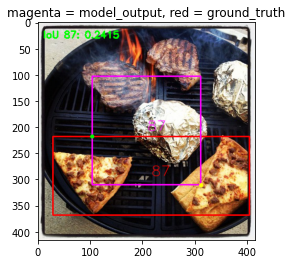

****************************************
[151, 291, 291, 332]
[104, 104, 311, 312]
[151, 291, 291, 312]
****************************************
[266, 257, 381, 299]
[103, 103, 310, 311]
[266, 257, 310, 299]
ground truth i 87, box = (151, 291, 291, 332) 
ground truth i 138, box = (266, 257, 381, 299) 

model output 87: nbox = (104, 104, 311, 312) 
model output 138: nbox = (103, 103, 310, 311) 



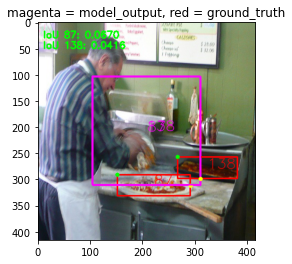

****************************************
[214, 203, 272, 222]
[104, 104, 312, 312]
[214, 203, 272, 222]
ground truth i 97, box = (214, 203, 272, 222) 

model output 97: nbox = (104, 104, 312, 312) 



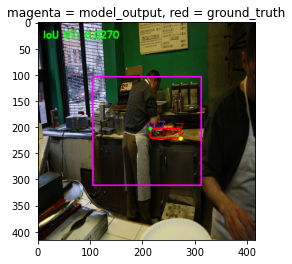

****************************************
[161, 163, 250, 352]
[104, 104, 312, 311]
[161, 163, 250, 311]
****************************************
[248, 158, 329, 324]
[103, 104, 310, 311]
[248, 158, 310, 311]
ground truth i 86, box = (161, 163, 250, 352) 
ground truth i 124, box = (248, 158, 329, 324) 

model output 86: nbox = (104, 104, 312, 311) 
model output 124: nbox = (103, 104, 310, 311) 



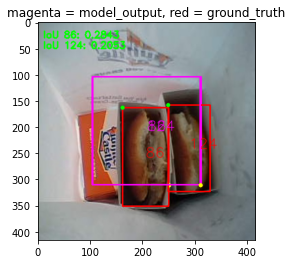

****************************************
[0, 166, 119, 310]
[104, 103, 312, 310]
[104, 166, 119, 310]
****************************************
[125, 159, 256, 305]
[103, 104, 311, 312]
[125, 159, 256, 305]
****************************************
[259, 116, 415, 313]
[104, 104, 312, 311]
[259, 116, 312, 311]
ground truth i 20, box = (0, 166, 119, 310) 
ground truth i 72, box = (125, 159, 256, 305) 
ground truth i 136, box = (259, 116, 415, 313) 

model output 20: nbox = (104, 103, 312, 310) 
model output 72: nbox = (103, 104, 311, 312) 
model output 136: nbox = (104, 104, 312, 311) 



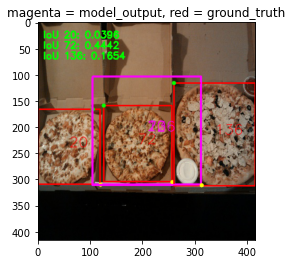

KeyboardInterrupt: 

In [6]:
THRESHOLD_OUTPUT = 0.4

for np_path in os.listdir("np_label")[15:45]:
    ground_truth = ""
    model_output = ""
    with open(f'np_label/{np_path}', 'rb') as f:
        np_mat = np.load(f)

    ko = np_mat.reshape(169,7)
    downby = 30
    img_path = f'two_objects/{np_path.split(".")[0]}.jpg'

    img = cv2.imread(img_path)
    img = np.expand_dims(img, axis=0)
    output = model.predict(img)
    img = np.squeeze(img)
    for k in range(0, 169):
        
        if ko[k, 0] > 0:
            
            pred = ko[k, :]
            
    #         print(pred)
            b1 = pred[1:5]
#             ground_truth += f"ground truth i {k}, box = {pred[0:5]} \n"
#             print(pred[:5])
            x1 = int((b1[0] - (b1[2]/2)) * 416 )
            y1 = int((b1[1] - (b1[3]/2)) * 416 )
            w1 = int(b1[2] * 416)
            h1 = int(b1[3] * 416)
            ground_truth += f"ground truth i {k}, box = {(x1, y1, x1 + w1, y1 + h1)} \n"
            
            cv2.rectangle(img, (x1, y1,  w1, h1), (0,0,255), 2)
            cv2.putText(img, str(k), (int(b1[0] * 416), int(b1[1] * 416)), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.9, (0,0,255), 1, cv2.LINE_AA)
           
            

#             model_output += f"model output {k}: nbox = {output[0,k,0:5]} \n"
            b2 = output[0,k,1:5]
            
            x2 = int((b2[0] - (b2[2]/2)) * 416 )
            y2 = int((b2[1] - (b2[3]/2)) * 416 )
            w2 = int(b2[2] * 416)
            h2 = int(b2[3] * 416)
            
            model_output += f"model output {k}: nbox = {(x2, y2, x2 + w2, y2 + h2)} \n"
            
            cv2.rectangle(img, (x2, y2, w2, h2), (255,0,255), 2)
            cv2.putText(img, str(k), (int(b2[0] * 416), int(b2[1] * 416)), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.9, (255,0,255), 1, cv2.LINE_AA)
           
            
            iou, int_area = bb_intersection_over_union(pred, output[0,k,:])
            
            
#             cv2.rectangle(img, (int_area[0], int_area[1]), (int_area[2], int_area[3]), (0,255,0), 2)

            cv2.circle(img, (int_area[0], int_area[1]), radius=4, color=(0, 255, 0), thickness=-1)
            cv2.circle(img, (int_area[2], int_area[3]), radius=4, color=(0, 255, 255), thickness=-1)
#             cv2.circle(img, (x1, y1), radius=4, color=(0, 255, 0), thickness=-1)
#             cv2.circle(img, (x1 + w1, y1 + h1), radius=4, color=(0, 255, 0), thickness=-1)
        
            cv2.putText(img, "IoU {}: {:.4f}".format(k, iou), (10, downby),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            downby += 20
    print(ground_truth)
    print(model_output)
    plt.imshow(img[...,::-1])
    plt.title('magenta = model_output, red = ground_truth')
    plt.show()




In [5]:
img_inputs = keras.Input(shape=(416, 416, 3))
x = layers.experimental.preprocessing.Rescaling(scale=1./255.)(img_inputs)

x = layers.Conv2D(98, (11, 11), strides=1)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=1)(x)

x = layers.Conv2D(98, (11, 11), strides=1)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=1)(x)

x = layers.Conv2D(192, (7, 7))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=1)(x)
x = layers.Conv2D(192, (7, 7))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=1)(x)

x = layers.Conv2D(252, (6, 6), strides=2)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Conv2D(192, (1, 1))(x)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.Conv2D(192, (5, 5), strides=2)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Conv2D(126, (1, 1))(x)
x = layers.LeakyReLU(alpha=0.1)(x)


x = layers.Conv2D(77, (3, 3), strides=1)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Conv2D(70, (1, 1))(x)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.Conv2D(35, (6, 6), strides=3)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Conv2D(7, (5, 5), strides=2)(x)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_regularizer='l2', activation='relu')(x)
# x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dense(13*13*(2+1*5), activation='sigmoid', kernel_regularizer='l2')(x)
x = layers.Reshape((13*13, (2 + 1 * 5)))(x)

model = keras.Model(img_inputs, x)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 406, 406, 98)      35672     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 406, 406, 98)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 405, 405, 98)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 395, 395, 98)      1162182   
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 395, 395, 98)     

In [6]:
img = cv2.imread("two_objects/000000000110.jpg")
img = np.expand_dims(img, axis=0)
output = model.predict(img)
output.shape

(1, 169, 7)

In [7]:
for i in range(5, 15):
    print(i , 7 * i)

5 35
6 42
7 49
8 56
9 63
10 70
11 77
12 84
13 91
14 98


In [8]:
def custom_loss(y_true, y_pred):
    
    y_true_class = y_true[..., 5 : 7]
    y_pred_class = y_pred[..., 5 : 7]
    
    
    y_true_xy = y_true[..., 1 : 3]
    y_pred_xy = y_pred[..., 1 : 3]
    
    
    
    y_true_wh = y_true[..., 3 : 5]
    y_pred_wh = y_pred[..., 3 : 5]
    
    
    y_true_conf = y_true[..., 0]
    y_pred_conf = y_pred[..., 0]
    
  
    cls_loss = K.sum(K.square(y_true_class - y_pred_class), axis= -1)
    xy_loss = K.sum(K.square(y_true_xy - y_pred_xy), axis= -1) * y_true_conf
    
#     print(K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis= -1) * y_true_conf)
    wh_loss = K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis= -1) * y_true_conf

    
    iou, _ = bb_intersection_over_union(y_true, y_pred)
    conf_loss = K.square(y_true_conf*iou - y_pred_conf)

    total_loss = xy_loss + conf_loss + cls_loss + wh_loss
    
    
    return total_loss

(1, 169, 7)
****************************************


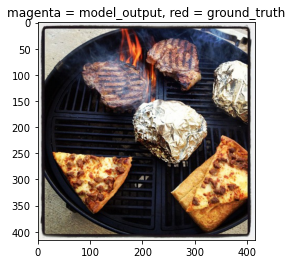

In [10]:
for np_path in os.listdir("np_label")[15:45]:
    ground_truth = ""
    model_output = ""
    
    with open(f'np_label/{np_path}', 'rb') as f:
        np_mat = np.load(f)

    g_truth = K.constant(np.expand_dims(np_mat.reshape(169,7), axis=0))
    print(g_truth.shape)
    img_path = f'two_objects/{np_path.split(".")[0]}.jpg'
    
    img = cv2.imread(img_path)
    img = np.expand_dims(img, axis=0)
    output = K.constant(model.predict(img))
    
    oo = custom_loss(g_truth, output)
    
    plt.imshow(np.squeeze(img)[...,::-1])
    plt.title('magenta = model_output, red = ground_truth')
    plt.show()
    break
    
    



In [98]:
tf.make_ndarray(oo)

AttributeError: 'Tensor' object has no attribute 'tensor_shape'

In [99]:
tf.__version__

'2.3.3'